# ***Importing and Installing***

In [ ]:
! pip install datasets transformers
! pip install git+https://github.com/huggingface/accelerate
! pip install sentencepiece
! pip install "tqdm==4.43.0"

# ***Problem Statement***
bert model to find email spam

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
import math, sys

from accelerate import Accelerator, DistributedType

from datasets import load_dataset, load_metric

from transformers import (
    AdamW,
    AutoModelForSequenceClassification,
    AutoConfig,
    AutoTokenizer,
    get_linear_schedule_with_warmup,
    set_seed,
)

from tqdm.auto import tqdm

import datasets
import transformers
import seaborn as sns
# ------------------- tokenizer and Model------------------
from transformers import BartForSequenceClassification
from transformers import BartTokenizer
from sklearn.model_selection import train_test_split

# ***Function Defination***





* tokenizer to tokenize the dataset





In [4]:

#---------------------- Tokenizer -------------------------------
def answer_tokenize_function_input(examples):
      input = tokenizer(examples["Message"], truncation=True, padding="max_length", max_length=500)   
      return input


def label(examples):
      if examples['Category'] == 'ham':
        return{'labels':1}
      else:
        return {'labels':0}



#---------------------- Load Data and integrates Collate_fn -------------------------------
def create_dataloaders(train_batch_size=16,eval_batch_size=16):
    train_dataloader = DataLoader(
        tokenized_datasets_train ,shuffle=True, batch_size=train_batch_size
    )
    eval_dataloader = DataLoader(
        tokenized_datasets_test, shuffle=False, batch_size=eval_batch_size
    )
    test_dataloader = DataLoader(
        tokenized_datasets_val, shuffle=False, batch_size=eval_batch_size
    )
    return train_dataloader, eval_dataloader,test_dataloader

# ***Import the MRQA dataset from hugging face and select the needed splits for a Squad-style extractive QA model.***

In [ ]:
from datasets import Dataset

dataset_train = load_dataset('csv', data_files="/content/drive/MyDrive/university_work/data/train_spam.csv")
dataset_test = load_dataset('csv', data_files="/content/drive/MyDrive/university_work/data/test.csv")
dataset_val = load_dataset('csv', data_files="/content/drive/MyDrive/university_work/data/val_spam.csv")



In [6]:
nickname = 'facebook/bart-base'
model_checkpoint = 'facebook/bart-base'
tokenizer = BartTokenizer.from_pretrained(model_checkpoint)

***Torch conversion was done in the collate_Fn so here the conversion are commented***

In [7]:
tokenized_datasets_train = dataset_train.map(answer_tokenize_function_input, remove_columns=["Message"])
tokenized_datasets_test = dataset_test.map(answer_tokenize_function_input, remove_columns=["Message"])
tokenized_datasets_val = dataset_val.map(answer_tokenize_function_input, remove_columns=["Message"])

In [8]:
tokenized_datasets_train = tokenized_datasets_train['train'].map(label, remove_columns=["Category"])
tokenized_datasets_train.set_format("torch")
tokenized_datasets_test = tokenized_datasets_test['train'].map(label, remove_columns=["Category"])
tokenized_datasets_test.set_format("torch")
tokenized_datasets_val = tokenized_datasets_val['train'].map(label, remove_columns=["Category"])
tokenized_datasets_val.set_format("torch")

 ***Defining Hypermarameter and Loading data***

In [9]:
train_dataloader, eval_dataloader,test_dataloader = create_dataloaders(16,16)

In [ ]:
accuracy = load_metric("accuracy")
precision = load_metric("precision")
recall = load_metric("recall")
f1 = load_metric("f1")
hyperparameters = {
    "learning_rate": 2e-5,
    "num_epochs": 1,
    "train_batch_size": 1,
    "eval_batch_size": 1, 
    "seed": 42,
}

# ***Defining Training and Model Structure***

In [22]:
from datetime import datetime
def training_function():
    accelerator = Accelerator()

    if accelerator.is_main_process:
        datasets.utils.logging.set_verbosity_warning()
        transformers.utils.logging.set_verbosity_info()
    else:
        datasets.utils.logging.set_verbosity_error()
        transformers.utils.logging.set_verbosity_error()

    train_dataloader, eval_dataloader,test_loader = create_dataloaders(
        train_batch_size=hyperparameters["train_batch_size"], eval_batch_size=hyperparameters["eval_batch_size"]
    )
    # The seed need to be set before we instantiate the model, as it will determine the random head.
    set_seed(hyperparameters["seed"])

    # The device is set automatically to match the available machine.
    # model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=3)#<----------------------------------------NUMBER OF LABELS
    model = BartForSequenceClassification.from_pretrained(model_checkpoint)               #<-------------------------------------------- QA model
    optimizer = AdamW(params=model.parameters(), lr=hyperparameters["learning_rate"])#<-------------------------------------------------OPTIMIZER
    
    model, optimizer, train_dataloader, eval_dataloader = accelerator.prepare(
        model, optimizer, train_dataloader, eval_dataloader
    )
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    model.to(device)
    num_epochs = hyperparameters["num_epochs"]
    # learning rate scheduler.
    lr_scheduler = get_linear_schedule_with_warmup(
        optimizer=optimizer,
        num_warmup_steps=100,
        num_training_steps=len(train_dataloader) * num_epochs,
    )


    progress_bar = tqdm(range(num_epochs * len(train_dataloader)), disable=not accelerator.is_main_process)
    # Main loop
    for epoch in range(num_epochs):
        model.train()
        for step, batch in enumerate(train_dataloader):
              batch = {k: v.to(device) for k, v in batch.items()}          
              outputs = model(**batch)
              loss = outputs.loss
              accelerator.backward(loss)
              
              optimizer.step()
              lr_scheduler.step()
              optimizer.zero_grad()
              progress_bar.update(1)

        model.eval()
        all_predictions = []
        all_labels = []
        all_pred_max_value = []
        for step,batch in enumerate(eval_dataloader):
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            all_pred_max_value.append(outputs.logits.argmax(dim=-1).tolist()[0])
            predictions = outputs.logits.argmax(dim=-1)
            accuracy.add_batch(predictions=predictions, references=batch["labels"])
            precision.add_batch(predictions=predictions, references=batch["labels"])
            recall.add_batch(predictions=predictions, references=batch["labels"])
            f1.add_batch(predictions=predictions, references=batch["labels"])
            # For TPUs this consolidates the work.
            # all_predictions.append(accelerator.gather(predictions))
            # all_labels.append(accelerator.gather(batch["labels"]))
            # for i in range(len(all_predictions)):
            #   metric.add_batch(predictions=all_predictions[i], references=all_labels[i])

        # all_predictions = torch.cat(all_predictions)[:len(tokenized_datasets['test'])]
        # all_labels = torch.cat(all_labels)[:len(tokenized_datasets['test'])]
        # print(all_predictions,all_labels)
        temp = {}
        temp['bert'] = all_pred_max_value
        temp =  pd.DataFrame.from_dict(temp)
        temp.to_csv("/content/drive/MyDrive/university_work/data/roc_bert.csv",index=False)
        eval_metric = accuracy.compute()
        now = datetime.now()#collects a timestamp

        metric_for_name = str(eval_metric)[15:20]

        model_name = metric_for_name + " " + nickname + " " + (str(now))
        # torch.save(model, "/content/drive/MyDrive/Deberta saved models/" + model_name + '.pt')#<------------------------SAVES THE MODEL TO DRIVE
        # model.save_pretrained("/content/drive/MyDrive/university_work/models/model"+str(epoch))
        accelerator.print(f"epoch {epoch}:", eval_metric)
                  
        precision_score = precision.compute()
        print(precision_score)
        recall_score = recall.compute()
        print(recall_score)
        f1_score = f1.compute()
        print(f1_score)

    # for step, batch in enumerate(test_dataloader):
    #           batch = {k: v.to(device) for k, v in batch.items()}           
    #           outputs = model(**batch)
    #           predictions = outputs.logits.argmax(dim=-1)
    #           accuracy.add_batch(predictions=predictions, references=batch["labels"])
    #           precision.add_batch(predictions=predictions, references=batch["labels"])
    #           recall.add_batch(predictions=predictions, references=batch["labels"])
    #           f1.add_batch(predictions=predictions, references=batch["labels"])
    #           # For TPUs this consolidates the work.
    #           # all_predictions.append(accelerator.gather(predictions))
    #           # all_labels.append(accelerator.gather(batch["labels"]))
    #           # for i in range(len(all_predictions)):
    #           #   metric.add_batch(predictions=all_predictions[i], references=all_labels[i])

    #       # all_predictions = torch.cat(all_predictions)[:len(tokenized_datasets['test'])]
    #       # all_labels = torch.cat(all_labels)[:len(tokenized_datasets['test'])]
    #       # print(all_predictions,all_labels)
          
    # accuracy_score = accuracy.compute()
    # print(accuracy_score)
    # precision_score = precision.compute()
    # print(precision_score)
    # recall_score = recall.compute()
    # print(recall_score)
    # f1_score = f1.compute()
    # print(f1_score)

# ***Running Model***

In [24]:
from accelerate import notebook_launcher
# This is actual training trigger
notebook_launcher(training_function)

Launching training on one GPU.


loading configuration file https://huggingface.co/facebook/bart-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/f5310d276a6d1648d00c32fadc8bf7b4607e0fbd5b404fc4a0045960aa2bdfdb.da0f3c0e2dc1c2fecc46738a1ebf4806f2fc36aae3d5c1947f21e063e7cab34b
Model config BartConfig {
  "_name_or_path": "bart-base",
  "activation_dropout": 0.1,
  "activation_function": "gelu",
  "add_bias_logits": false,
  "add_final_layer_norm": false,
  "architectures": [
    "BartModel"
  ],
  "attention_dropout": 0.1,
  "bos_token_id": 0,
  "classif_dropout": 0.1,
  "classifier_dropout": 0.0,
  "d_model": 768,
  "decoder_attention_heads": 12,
  "decoder_ffn_dim": 3072,
  "decoder_layerdrop": 0.0,
  "decoder_layers": 6,
  "decoder_start_token_id": 2,
  "dropout": 0.1,
  "early_stopping": true,
  "encoder_attention_heads": 12,
  "encoder_ffn_dim": 3072,
  "encoder_layerdrop": 0.0,
  "encoder_layers": 6,
  "eos_token_id": 2,
  "forced_eos_token_id": 2,
  "gradient_checkpointing": false

epoch 0: {'accuracy': 0.9905982905982906}
{'precision': 0.9980119284294234}
{'recall': 0.9911154985192497}
{'f1': 0.9945517582961863}


In [ ]:
# del model
# del pytorch_model
# del trainer
torch.cuda.empty_cache()

In [11]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
plt.style.use('seaborn')

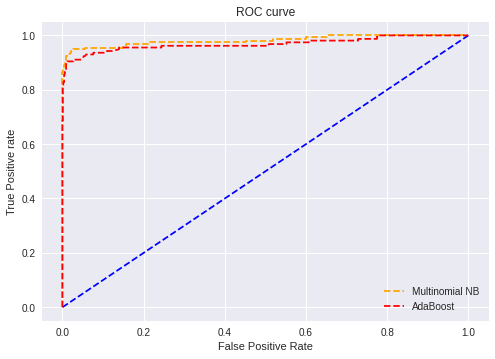

In [13]:

data_machine = pd.read_csv("/content/drive/MyDrive/university_work/data/roc.csv")

data_ber = pd.read_csv("/content/drive/MyDrive/university_work/data/roc_bert.csv")

data_test = pd.read_csv("/content/drive/MyDrive/university_work/data/test.csv")

y_test = data_test['Category'].apply(lambda x: 0 if x == 'ham' else 1)

random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)
fpr1, tpr1, thresh1 = roc_curve(y_test, data_machine['Multinomial NB'], pos_label=1)
fpr2, tpr2, thresh2 = roc_curve(y_test, data_machine['AdaBoost'], pos_label=1)
fpr3, tpr3, thresh23= roc_curve(y_test, data_ber['bert'], pos_label=1)
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
plt.plot(fpr1, tpr1, linestyle='--',color='orange', label='Multinomial NB')
plt.plot(fpr2, tpr2, linestyle='--',color='red', label='AdaBoost')
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('ROC',dpi=300)
plt.show();

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
